In [1]:
import pandas as pd
import sqlite3
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style("whitegrid")
con = sqlite3.connect("data/app.db")
df = pd.read_sql_query("SELECT * from report_histo", con)
excel = pd.read_excel("data/Dossier_Patient_clean_myocapt_KC_v6.xlsx")

In [2]:
df.to_csv("dump_historeport_table.csv", index=False)

In [3]:
def table_to_df(df):
    # Transformation de la table SQLite en dataframe en parsant l'arbre JSON
    # Return un dictionnaire et une liste de colonnes (les features histo)
    tree_as_dict = {}
    features_col = []
    for index, row in df.iterrows():
        tree_as_dict.setdefault("id", []).append(row[0])
        tree_as_dict.setdefault("patient_id", []).append(row[1])
        tree_as_dict.setdefault("expert_id", []).append(row[2])
        tree_as_dict.setdefault("biopsie_id", []).append(row[3])
        tree_as_dict.setdefault("muscle_prelev", []).append(row[4])
        tree_as_dict.setdefault("age_biopsie", []).append(row[5])
        tree_as_dict.setdefault("date_envoie", []).append(row[6])
        tree_as_dict.setdefault("gene_diag", []).append(row[7])
        tree_as_dict.setdefault("comment", []).append(row[9])
        tree_as_dict.setdefault("conclusion", []).append(row[10])
        tree_as_dict.setdefault("datetime", []).append(row[11])

        my_tree = json.loads(row[8])
        for feature in my_tree:
            tree_as_dict.setdefault(feature["text"], []).append(float(feature["data"].get("presence", -0.25)))
            if index==0:
                features_col.append(feature["text"])
    return tree_as_dict, features_col
tree_as_dict, features_col = table_to_df(df)
df2 = pd.DataFrame.from_dict(tree_as_dict)

# Simplifier le diagnostic en regroupant les sous-type sous 5 catégories: Némaline, Core Myo, CentroNuc ou UNCLEAR ou OTHER
df2 = df2.replace({"COM_CCD":"COM", "COM_MMM":"COM", "NM_CAP":"NM", "CFTD":"OTHER", "NON_CM":"OTHER","CM":"UNCLEAR"})
# Simplification de l'encodage:
# No Info (-0.25) -> 0. 
# Absence reste 0
# Et Présence faible/modéré/forte (0.25 0.5 0.75) -> 1
df2 = df2.replace({-0.25:np.nan, 0.25:1, 0.5:1, 0.75:1})


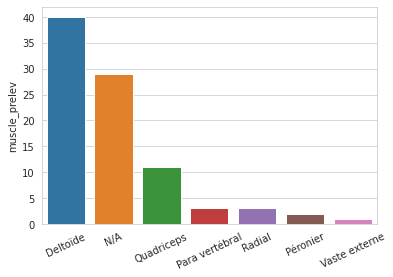

In [4]:
muscle_prelev = df2["muscle_prelev"].value_counts()
# Empty index to N/A
as_list = muscle_prelev.index.tolist()
idx = as_list.index('')
as_list[idx] = 'N/A'
muscle_prelev.index = as_list
sns.barplot(x=muscle_prelev.index, y=muscle_prelev)
var = plt.xticks(rotation=25)

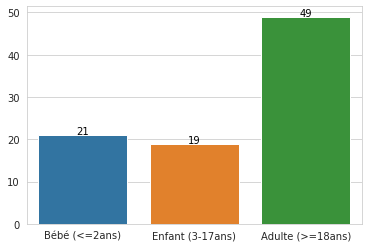

In [5]:
age_biopsie = df2["age_biopsie"].value_counts()
bebe = age_biopsie.where(age_biopsie.index<=2).sum()
enfant = age_biopsie.where((age_biopsie.index>2) & (age_biopsie.index<18)).sum()
adulte = age_biopsie.where(age_biopsie.index>=18).sum()
g = sns.barplot(x=["Bébé (<=2ans)", "Enfant (3-17ans)", "Adulte (>=18ans)"], y=[bebe, enfant, adulte])
for i in range(3):
    g.text(i, [bebe, enfant, adulte][i]+0.1, int([bebe, enfant, adulte][i]), color='black', ha="center")

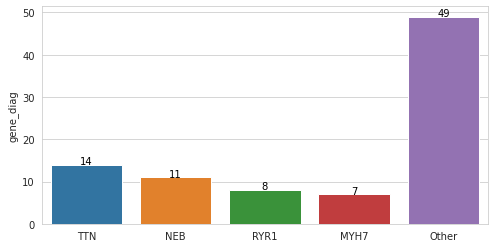

In [23]:
gene_diag = df2["gene_diag"].value_counts()[0:4]
gene_diag["Other"] = 89-(14+11+8+7)
fig_dims = (8, 4)
fig, ax = plt.subplots(figsize=fig_dims)
g = sns.barplot(x=gene_diag.index, y=gene_diag, ax=ax)
for i in range(len(gene_diag)):
    g.text(i, gene_diag[i]+0.1, gene_diag[i], color='black', ha="center")
#var = plt.xticks(rotation=90)


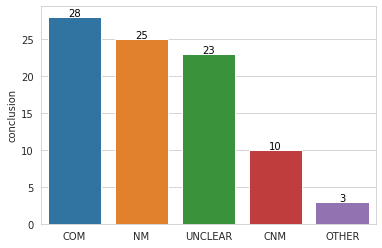

In [7]:
# Merge sub types for stats
conclusion = df2["conclusion"].value_counts()
g = sns.barplot(x=conclusion.index, y=conclusion)
for i in range(len(conclusion)):
    g.text(i, conclusion[i]+0.1, conclusion[i], color='black', ha="center")

In [8]:
df2[features_col].sum().sort_values(ascending=False)[0:10]

Taille Inégale                                 79.0
Prédominance Fibre Type 1                      66.0
Noyaux Centralisé                              43.0
Type 1 Atrophiées (petites)                    43.0
Désorganisation structurelle                   42.0
Matériel Fuscinophile: Amas/Aggrégat sombre    39.0
Type 2 Atrophiées (petites)                    32.0
Activité Oxy: Zone Claire (pâle)               31.0
Noyaux Internalisé                             28.0
Sans Topographie                               28.0
dtype: float64

In [9]:
# Les features les plus présent chez les NM
df2.where(df2["conclusion"]=="NM")[features_col].sum().sort_values(ascending=False)[0:10]

Matériel Fuscinophile: Amas/Aggrégat sombre             22.0
Taille Inégale                                          22.0
Bâtonnets - Rods                                        20.0
Prédominance Fibre Type 1                               18.0
Type 1 Atrophiées (petites)                             15.0
Désorganisation structurelle                            12.0
Type 2 Atrophiées (petites)                             10.0
Noyaux Centralisé                                        8.0
Activité ATPasique Anormale Localement (Zone Claire)     7.0
Uniformité de Type                                       7.0
dtype: float64

In [10]:
# Les features les plus présent chez les Centro nuclear myo
df2.where(df2["conclusion"]=="CNM")[features_col].sum().sort_values(ascending=False)[0:10]

Noyaux Centralisé                       9.0
Taille Inégale                          8.0
Prédominance Fibre Type 1               7.0
Désorganisation structurelle            4.0
HETG: Bord arrondis                     3.0
Type 1 Atrophiées (petites)             3.0
Uniformité de Type                      2.0
Necklace Fibers                         2.0
Augmentation du Collagène Endosymial    2.0
Noyaux Internalisé                      2.0
dtype: float64

In [11]:
# Pour le learning futur: sortir la matrice de 0/1 en .csv
df2 = df2.replace({"UNCLEAR":"OTHER"})
# df2.to_csv("histo_feature.csv", index=False)

In [12]:
df2.to_csv("histo_feature.csv", index=False)

In [13]:
stat_per_gene = {}
all_genes = list(set(df2.gene_diag.to_list()))
for i in all_genes:
    ds = df2[df2["gene_diag"]==i][features_col].sum().sort_values(ascending=False)
    nrow = len(df2[df2["gene_diag"]==i])
    ds = ds / nrow * 100
    stat_per_gene[i] = {}
    stat_per_gene[i]["n"] = nrow
    stat_per_gene[i]["feature"] = ds[ds>0].round().to_dict()
stat_per_gene

{'ACTA1': {'n': 3,
  'feature': {'Matériel Fuscinophile: Amas/Aggrégat sombre': 100.0,
   'Bâtonnets - Rods': 100.0,
   'Taille Inégale': 67.0,
   'Activité ATPasique Anormale Localement (Zone Claire)': 67.0,
   'Type 1 Atrophiées (petites)': 67.0,
   'Type 2 Atrophiées (petites)': 67.0,
   'Zone sans activité ATPase': 67.0,
   'Noyaux Internalisé': 67.0,
   'Activité Oxy: Périphérique': 33.0,
   'Coloration PAS: Irrégulière / Inégale': 33.0,
   'Matériel Fuscinophile: Granuleux': 33.0,
   'Activité Phospholipases Anormale Localement': 33.0,
   'Zone Claire en Croissant Périphérique': 33.0,
   'Majorité de la Fibre': 33.0,
   'Activité Oxy: En Croissant': 33.0,
   'Prédominance Fibre Type 2': 33.0,
   'Activité Oxy: Zone Claire (pâle)': 33.0,
   'Augmentation du Collagène Endosymial': 33.0,
   'Uniformité de Type': 33.0,
   'Prédominance Fibre Type 1': 33.0,
   'Activité Oxy: Cerné': 33.0,
   'Activité Oxy: Myotubulaire': 33.0,
   'Fibres 1 Groupées': 33.0,
   'Activité Acide-Résistant

In [14]:
stat_per_diag = {}
all_diag = list(set(df2.conclusion.to_list()))
for i in all_diag:
    ds = df2[df2["conclusion"]==i][features_col].sum().sort_values(ascending=False)
    nrow = len(df2[df2["conclusion"]==i])
    ds = ds / nrow * 100
    stat_per_diag[i] = {}
    stat_per_diag[i]["n"] = nrow
    stat_per_diag[i]["feature"] = ds[ds>0].round().to_dict()
stat_per_diag

{'NM': {'n': 25,
  'feature': {'Matériel Fuscinophile: Amas/Aggrégat sombre': 88.0,
   'Taille Inégale': 88.0,
   'Bâtonnets - Rods': 80.0,
   'Prédominance Fibre Type 1': 72.0,
   'Type 1 Atrophiées (petites)': 60.0,
   'Désorganisation structurelle': 48.0,
   'Type 2 Atrophiées (petites)': 40.0,
   'Noyaux Centralisé': 32.0,
   'Activité ATPasique Anormale Localement (Zone Claire)': 28.0,
   'Uniformité de Type': 28.0,
   'Activité Oxy: Zone Claire (pâle)': 24.0,
   'Noyaux Internalisé': 24.0,
   'Activité Oxy: Zone Inclusion Non Colorée': 20.0,
   'Matériel Fuscinophile: Périphériques': 20.0,
   'Matériel Fuscinophile: Granuleux': 16.0,
   'Zone sans activité ATPase': 16.0,
   'Coloration PAS Anormale Localement (Surcharge)': 16.0,
   'Sans Topographie': 16.0,
   'Augmentation Tissu Conjonctif': 16.0,
   'HETG: Anguleuse': 16.0,
   'HETG: Bord arrondis': 16.0,
   'Prélèvement Anormal': 16.0,
   'Coloration Soudan: Anormale (Surchage en Lipides)': 12.0,
   'Activité COX Anormale Loca

In [15]:
import json

with open("data/stat_per_gene.json","w") as f:
    json.dump(stat_per_gene, f, indent=4, ensure_ascii=False)
with open("data/stat_per_diag.json","w") as f:
    json.dump(stat_per_diag, f, indent=4, ensure_ascii=False)